# CONFIG BUILDER
- 모델 학습에 필요한 configuration을 json 파일로 저장
    - 학습 parameters 설정
    - 데이터 로드 및 확인
    
- 생성된 json 파일은 모델 학습에 사용 됨

## 1) Packages  Load

In [1]:
# Package Import
import os
import sys
import cv2
sys.path.append(os.path.abspath('./src'))
os.environ["CUDA_VISIBLE_DEVICES"]="99"

from config import config as cfg
from config import finalize_configs

from data import get_train_dataflow
from data import get_eval_dataflow
from tensorpack.dataflow import PrintData

from dataset import register_custom_data
from dataset.custom_data import CustomDataset
from dataset.custom_data import COCODetection

import numpy as np
import matplotlib.pyplot as plt

import os
import json

## 2) 모델 Parameter 설정

In [2]:
# 변경하고자 하는 Configuration 설정

# Config (json) 파일이 저장될 경로
CONFIG_NAME = '1215_BB_AP_AT1'
SAVE_PATH = './configs/'+CONFIG_NAME+'_config.json'

# 데이터 관련 Config (필수 수정)
cfg.DATA.BASEDIR = os.path.abspath('./custom_data/')

cfg.DATA.TRAIN.train.image_dir  = 'train'
cfg.DATA.TRAIN.train.annot_path = 'annotations/train.json'
cfg.DATA.VAL.eval.image_dir = 'eval'
cfg.DATA.VAL.eval.annot_path ='annotations/eval.json'

cfg.DATA.CLASS_NAMES = ['3','10','13','16','17']
cfg.DATA.NUM_CATEGORY = 5

# 모델 학습관련 Configuration (별도의 설정이 없으면 Default로 실행)
cfg.MODE_MASK=False
cfg.BACKBONE.WEIGHTS = os.path.abspath('./initial_weight/ImageNet-R50-AlignPadding.npz')

cfg.BACKBONE.RESNET_NUM_BLOCKS = [3, 4, 6, 3]     # for resnet50
# RESNET_NUM_BLOCKS = [3, 4, 23, 3]    # for resnet101
cfg.BACKBONE.FREEZE_AFFINE = False   # do not train affine parameters inside norm layers
cfg.BACKBONE.NORM = 'FreezeBN'  # options: FreezeBN, SyncBN, GN, None
cfg.BACKBONE.FREEZE_AT = 2  # options: 0, 1, 2. How many stages in backbone to freeze (not training)

# Use a base model with TF-preferred padding mode,
# which may pad more pixels on right/bottom than top/left.
# See https://github.com/tensorflow/tensorflow/issues/18213
# In tensorpack model zoo, ResNet models with TF_PAD_MODE=False are marked with "-AlignPadding".
# All other models under `ResNet/` in the model zoo are using TF_PAD_MODE=True.
# Using either one should probably give the same performance.
# We use the "AlignPadding" one just to be consistent with caffe2.
cfg.BACKBONE.TF_PAD_MODE = False
cfg.BACKBONE.STRIDE_1X1 = False  # True for MSRA models

# schedule -----------------------
cfg.TRAIN.NUM_GPUS = None         # by default, will be set from code
cfg.TRAIN.WEIGHT_DECAY = 1e-4
cfg.TRAIN.BASE_LR = 1e-2  # defined for total batch size=8. Otherwise it will be adjusted automatically
cfg.TRAIN.WARMUP = 1000   # in terms of iterations. This is not affected by #GPUs
cfg.TRAIN.WARMUP_INIT_LR = 1e-5  # defined for total batch size=8. Otherwise it will be adjusted automatically
cfg.TRAIN.STEPS_PER_EPOCH = 500
cfg.TRAIN.STARTING_EPOCH = 1  # the first epoch to start with, useful to continue a training

# LR_SCHEDULE means equivalent steps when the total batch size is 8.
# It can be either a string like "3x" that refers to standard convention, or a list of int.
# LR_SCHEDULE=3x is the same as LR_SCHEDULE=[420000, 500000, 540000], which
# means to decrease LR at steps 420k and 500k and stop training at 540k.
# When the total bs!=8, the actual iterations to decrease learning rate, and
# the base learning rate are computed from BASE_LR and LR_SCHEDULE.
# Therefore, there is *no need* to modify the config if you only change the number of GPUs.
cfg.TRAIN.LR_SCHEDULE = "1x"      # "1x" schedule in detectron
cfg.TRAIN.EVAL_PERIOD = 1  # period (epochs) to run evaluation
cfg.TRAIN.CHECKPOINT_PERIOD = 1  # period (epochs) to save model

# preprocessing --------------------
# Alternative old (worse & faster) setting: 600
cfg.PREPROC.TRAIN_SHORT_EDGE_SIZE = [800, 800]  # [min, max] to sample from
cfg.PREPROC.TEST_SHORT_EDGE_SIZE = 800
cfg.PREPROC.MAX_SIZE = 1333
# mean and std in RGB order.
# Un-scaled version: [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
cfg.PREPROC.PIXEL_MEAN = [123.675, 116.28, 103.53]
cfg.PREPROC.PIXEL_STD = [58.395, 57.12, 57.375]

# anchors -------------------------
cfg.RPN.ANCHOR_STRIDE = 16
cfg.RPN.ANCHOR_SIZES = (32, 64, 128, 256, 512)   # sqrtarea of the anchor box
cfg.RPN.ANCHOR_RATIOS = (0.5, 1., 2.)
cfg.RPN.POSITIVE_ANCHOR_THRESH = 0.7
cfg.RPN.NEGATIVE_ANCHOR_THRESH = 0.3

# rpn training -------------------------
cfg.RPN.FG_RATIO = 0.5  # fg ratio among selected RPN anchors
cfg.RPN.BATCH_PER_IM = 256  # total (across FPN levels) number of anchors that are marked valid
cfg.RPN.MIN_SIZE = 0
cfg.RPN.PROPOSAL_NMS_THRESH = 0.7
# Anchors which overlap with a crowd box (IOA larger than threshold) will be ignored.
# Setting this to a value larger than 1.0 will disable the feature.
# It is disabled by default because Detectron does not do this.
cfg.RPN.CROWD_OVERLAP_THRESH = 9.99
cfg.RPN.HEAD_DIM = 1024      # used in C4 only

# RPN proposal selection -------------------------------
# for C4
cfg.RPN.TRAIN_PRE_NMS_TOPK = 12000
cfg.RPN.TRAIN_POST_NMS_TOPK = 2000
cfg.RPN.TEST_PRE_NMS_TOPK = 6000
cfg.RPN.TEST_POST_NMS_TOPK = 1000   # if you encounter OOM in inference, set this to a smaller number
# for FPN, #proposals per-level and #proposals after merging are (for now) the same
# if FPN.PROPOSAL_MODE = 'Joint', these options have no effect
cfg.RPN.TRAIN_PER_LEVEL_NMS_TOPK = 2000
cfg.RPN.TEST_PER_LEVEL_NMS_TOPK = 1000

# fastrcnn training ---------------------
cfg.FRCNN.BATCH_PER_IM = 512
cfg.FRCNN.BBOX_REG_WEIGHTS = [10., 10., 5., 5.]  # Slightly better setting: 20, 20, 10, 10
cfg.FRCNN.FG_THRESH = 0.5
cfg.FRCNN.FG_RATIO = 0.25  # fg ratio in a ROI batch

# FPN -------------------------
cfg.FPN.ANCHOR_STRIDES = (4, 8, 16, 32, 64)  # strides for each FPN level. Must be the same length as ANCHOR_SIZES
cfg.FPN.PROPOSAL_MODE = 'Level'  # 'Level', 'Joint'
cfg.FPN.NUM_CHANNEL = 256
cfg.FPN.NORM = 'None'  # 'None', 'GN'
# The head option is only used in FPN. For C4 models, the head is C5
cfg.FPN.FRCNN_HEAD_FUNC = 'fastrcnn_2fc_head'
# choices: fastrcnn_2fc_head, fastrcnn_4conv1fc_{,gn_}head
cfg.FPN.FRCNN_CONV_HEAD_DIM = 256
cfg.FPN.FRCNN_FC_HEAD_DIM = 1024
cfg.FPN.MRCNN_HEAD_FUNC = 'maskrcnn_up4conv_head'   # choices: maskrcnn_up4conv_{,gn_}head

# Mask R-CNN
cfg.MRCNN.HEAD_DIM = 256
cfg.MRCNN.ACCURATE_PASTE = True  # slightly more aligned results, but very slow on numpy

# Cascade R-CNN, only available in FPN mode
cfg.FPN.CASCADE = False
cfg.CASCADE.IOUS = [0.5, 0.6, 0.7]
cfg.CASCADE.BBOX_REG_WEIGHTS = [[10., 10., 5., 5.], [20., 20., 10., 10.], [30., 30., 15., 15.]]

# testing -----------------------
cfg.TEST.FRCNN_NMS_THRESH = 0.5

# Smaller threshold value gives significantly better mAP. But we use 0.05 for consistency with Detectron.
# mAP with 1e-4 threshold can be found at https://github.com/tensorpack/tensorpack/commit/26321ae58120af2568bdbf2269f32aa708d425a8#diff-61085c48abee915b584027e1085e1043  # noqa
cfg.TEST.RESULT_SCORE_THRESH = 0.05
cfg.TEST.RESULT_SCORE_THRESH_VIS = 0.5   # only visualize confident results
cfg.TEST.RESULTS_PER_IM = 100

In [3]:
# Json 파일로 Config 저장
cfg_dict = cfg.to_dict()
with open(SAVE_PATH, "w") as json_file: json.dump(cfg_dict, json_file)

## 3) Configuration 및 데이터 로드 확인

In [4]:
# Configuration 로드
cfg.update_from_json(SAVE_PATH)
cfg.DATA.CLASS_NAMES = ['BG'] + cfg.DATA.CLASS_NAMES

In [5]:
# 데이터 셋 로드 및 최종 Configuration 출력
register_custom_data()
finalize_configs(True)

[1215 13:25:02 @config.py:350] Config: ------------------------------------------
{'BACKBONE': {'FREEZE_AFFINE': False,
              'FREEZE_AT': 2,
              'NORM': 'FreezeBN',
              'RESNET_NUM_BLOCKS': [3, 4, 6, 3],
              'STRIDE_1X1': False,
              'TF_PAD_MODE': False,
              'WEIGHTS': '/raid/intelligence/jupyterhub/notebook/nvidia/jingwan/FasterRCNN/initial_weight/ImageNet-R50-AlignPadding.npz'},
 'CASCADE': {'BBOX_REG_WEIGHTS': [[10.0, 10.0, 5.0, 5.0], [20.0, 20.0, 10.0, 10.0],
                                  [30.0, 30.0, 15.0, 15.0]],
             'IOUS': [0.5, 0.6, 0.7]},
 'DATA': {'ABSOLUTE_COORD': True,
          'BASEDIR': '/raid/intelligence/jupyterhub/notebook/nvidia/jingwan/FasterRCNN/custom_data',
          'CLASS_NAMES': ['BG', '3', '10', '13', '16', '17'],
          'FILTER_EMPTY_ANNOTATIONS': True,
          'NUM_CATEGORY': 5,
          'NUM_WORKERS': 10,
          'TRAIN': {'train': {'annot_path': 'annotations/train.json', 'ima

In [6]:
# 데이터 Flow 확인 (이미지 별 annotation 확인)
train_dataflow = get_train_dataflow() # 학습 데이터 셋
eval_dataflow = get_eval_dataflow('eval') # 검증 데이터 셋

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[1215 13:25:05 @custom_data.py:245] Instances loaded from /raid/intelligence/jupyterhub/notebook/nvidia/jingwan/FasterRCNN/custom_data/annotations/train.json.


100%|██████████| 278/278 [00:00<00:00, 16955.31it/s]

[1215 13:25:05 @timer.py:45] Load annotations for train.json finished, time:0.0202 sec.
[1215 13:25:05 @data.py:62] Ground-Truth category distribution:
|  class  | #box   | class   | #box   | class   | #box   |
|:-------:|:-------|:--------|:-------|:--------|:-------|
|    3    | 78     | 10      | 352    | 13      | 290    |
|   16    | 108    | 17      | 267    |         |        |
|  total  | 1095   |         |        |         |        |
[1215 13:25:05 @data.py:352] Filtered 0 images which contain no non-crowd groudtruth boxes. Total #images for training: 278
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[1215 13:25:05 @custom_data.py:245] Instances loaded from /raid/intelligence/jupyterhub/notebook/nvidia/jingwan/FasterRCNN/custom_data/annotations/eval.json.



100%|██████████| 68/68 [00:00<00:00, 251510.29it/s]

[1215 13:25:05 @timer.py:45] Load annotations for eval.json finished, time:0.0019 sec.
[1215 13:25:05 @data.py:380] Found 68 images for inference.


[1215 13:25:06 @argtools.py:138] WRN Starting a process with 'fork' method is efficient but not safe and may cause deadlock or crash.Use 'forkserver' or 'spawn' method instead if you run into such issues.See https://docs.python.org/3/library/multiprocessing.html#contexts-and-start-methods on how to set them.
[1215 13:25:06 @argtools.py:138] WRN "import prctl" failed! Install python-prctl so that processes can be cleaned with guarantee.
[1215 13:25:06 @common.py:839] Contents of DataFlow:
datapoint 0/2 with 13 components consists of
  image: ndarray:float32 of shape (800, 800, 3) in range [0.0, 255.0]
  anchor_labels_lvl2: ndarray:int32 of shape (336, 336, 3) in range [-1, 0]
  anchor_boxes_lvl2: ndarray:float32 of shape (336, 336, 3, 4) in range [0.0, 0.0]
  anchor_labels_lvl3: ndarray:int32 of shape (168, 168, 3) in range [-1, 0]
  anchor_boxes_lvl3: ndarray:float32 of shape (168, 168, 3, 4) in range [0.0, 0.0]
  anchor_labels_lvl4: ndarray:int32 of shape (84, 84, 3) in range [-1, 1]


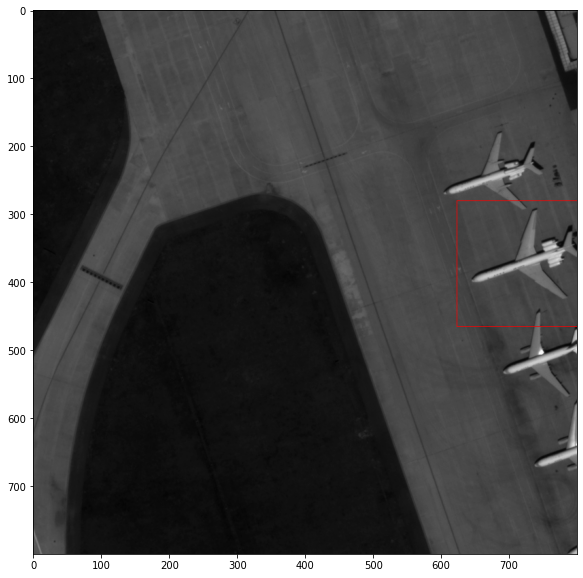

datapoint 1/2 with 13 components consists of
  image: ndarray:float32 of shape (800, 800, 3) in range [0.0, 255.0]
  anchor_labels_lvl2: ndarray:int32 of shape (336, 336, 3) in range [-1, 1]
  anchor_boxes_lvl2: ndarray:float32 of shape (336, 336, 3, 4) in range [0.0, 200.0]
  anchor_labels_lvl3: ndarray:int32 of shape (168, 168, 3) in range [-1, 0]
  anchor_boxes_lvl3: ndarray:float32 of shape (168, 168, 3, 4) in range [0.0, 0.0]
  anchor_labels_lvl4: ndarray:int32 of shape (84, 84, 3) in range [-1, 0]
  anchor_boxes_lvl4: ndarray:float32 of shape (84, 84, 3, 4) in range [0.0, 0.0]
  anchor_labels_lvl5: ndarray:int32 of shape (42, 42, 3) in range [-1, 0]
  anchor_boxes_lvl5: ndarray:float32 of shape (42, 42, 3, 4) in range [0.0, 0.0]
  anchor_labels_lvl6: ndarray:int32 of shape (21, 21, 3) in range [-1, -1]
  anchor_boxes_lvl6: ndarray:float32 of shape (21, 21, 3, 4) in range [0.0, 0.0]
  gt_boxes: ndarray:float32 of shape (7, 4) in range [0.0, 200.0]
  gt_labels: ndarray:int32 of sha

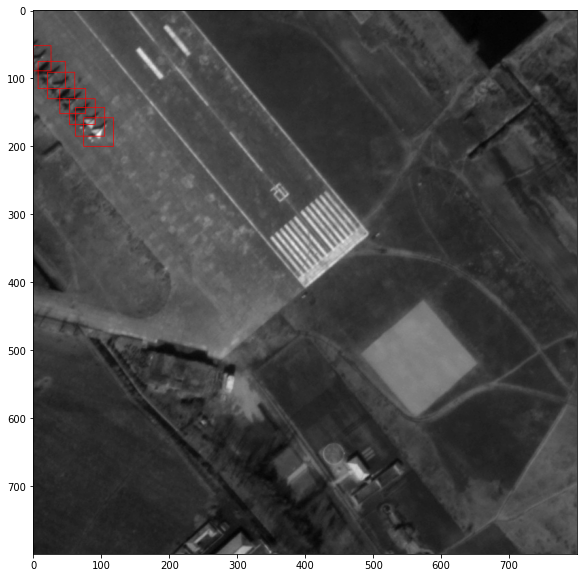

2 446.0 255.0 475.0 296.0
2 430.0 246.0 460.0 288.0
2 376.0 215.0 410.0 262.0


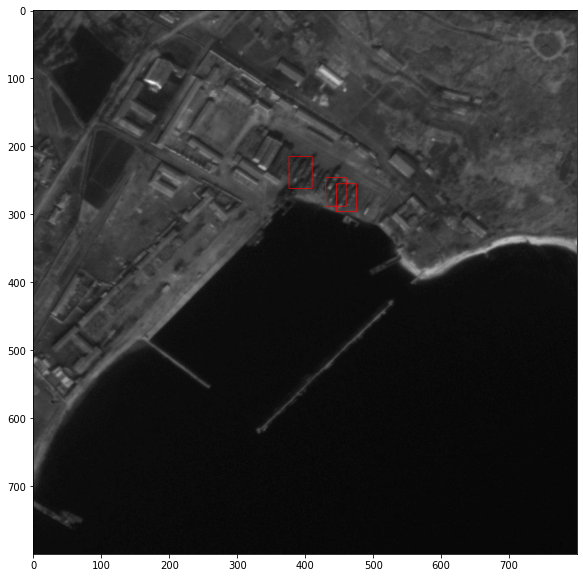

In [7]:
# 정상적으로 데이터가 로드 되었는지 확인
data_info = PrintData(train_dataflow, 2)
data_info.reset_state()

i = 0
for info in data_info.get_data():
    
    img = info['image'].astype(np.uint8)[..., ::-1].copy()
    
    for idx, (x1, y1, x2, y2) in enumerate(info['gt_boxes']):
        img = cv2.rectangle(img,(int(x1),int(y1)),(int(x2),int(y2)),(255,0,0),1)
        label = info['gt_labels'][idx]
        print (info['gt_labels'][idx],x1,y1,x2,y2)
    
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    
    if i > 1: break
    i += 1

## DATA INFO